In [ ]:
# author Michael Munz
#
# in depth analysis
# in -> 1.1-munz-data-exploration_locations
# in -> 1.1-munz-data-preprocessing_locations
# quantiative (numerical)
#     histogram :max_speed, :road_lanes
# qualitative (categorical)
#     countplot :road_gradient, :road_view,
#               :road_traffic_circulation, :road_category, :road_surface_condition
# qualitative vs. quantiative
#     correlation heatmap
#     scatterplot :road_lanes, :max_speed
#     boxplot :road_type, :road_category, :road_view, :road_traffic_circulation
#             :road_surface_condition
#     contingency table :road_category, :road_traffic_circulation
#     chi-square
#     cramer's v
# out <- n/a

In [36]:
# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from scipy.stats import chi2_contingency
from joblib import dump, load


In [37]:
# ----
# load
# ----
df_orig = load( '../../data/processed/1_exploration/1.1-munz-data-exploration_locations.joblib' )
df_outlier_cleaned = load( '../../data/processed/2_preprocessing/1.0.2-munz-data-preprocessing_locations.joblib' )
df = load( '../../data/processed/2_preprocessing/1.1-munz-data-preprocessing_locations.joblib' )



In [38]:
# preview
display( df.shape )
display( df.head(2) )
display( df.info() )
display( df.describe() )

(359510, 9)

,acc_num,loca_road_cat,loca_traffic_circul,loca_road_lanes,loca_road_gradient,loca_road_view,loca_road_surface_cond,loca_accident,loca_max_speed
0,201900000001,1,3,10.0,1,2.0,1.0,1,70.0
1,201900000002,1,1,2.0,4,2.0,1.0,1,70.0


<class 'pandas.core.frame.DataFrame'>
Index: 359510 entries, 0 to 359511
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   acc_num                 359510 non-null  int64  
 1   loca_road_cat           359510 non-null  int64  
 2   loca_traffic_circul     359510 non-null  int64  
 3   loca_road_lanes         348846 non-null  float64
 4   loca_road_gradient      359510 non-null  int64  
 5   loca_road_view          359272 non-null  float64
 6   loca_road_surface_cond  359200 non-null  float64
 7   loca_accident           359510 non-null  int64  
 8   loca_max_speed          347911 non-null  float64
dtypes: float64(4), int64(5)
memory usage: 27.4 MB


None

,acc_num,loca_road_cat,loca_traffic_circul,loca_road_lanes,loca_road_gradient,loca_road_view,loca_road_surface_cond,loca_accident,loca_max_speed
count,3.595100e+05,359510.000000,359510.000000,348846.000000,359510.000000,359272.000000,359200.000000,359510.000000,347911.00000
mean,2.021674e+11,4.068388,1.837493,2.335684,1.229524,1.297371,1.272575,1.556905,58.73840
std,1.741803e+08,1.279888,0.743214,1.271620,0.541959,0.672149,0.829875,1.428361,22.19312
min,2.019000e+11,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.00000
25%,2.020000e+11,4.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,50.00000
50%,2.022000e+11,4.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,50.00000
75%,2.023000e+11,5.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,80.00000
max,2.024001e+11,8.000000,4.000000,12.000000,4.000000,4.000000,9.000000,7.000000,180.00000


In [39]:
# modalities

# 1 get modalities via unique()
modalities = df.apply( lambda col: col.unique() )

# 2 get frequencies via value_counts
modalities_count = df.apply( lambda col: col.nunique() )

# 3 create DF
modalities_df = pd.DataFrame(
    {
        'modality_counts': modalities_count,
        'modalities': modalities
    }
)

display( modalities_df )


,modality_counts,modalities
acc_num,327628,"[201900000001, 201900000002, 201900000003, 201..."
loca_road_cat,8,"[1, 5, 4, 3, 2, 7, 6, 8]"
loca_traffic_circul,5,"[3, 1, 2, 0, 4]"
loca_road_lanes,13,"[10.0, 2.0, 8.0, 5.0, 3.0, 4.0, 6.0, 1.0, 7.0,..."
loca_road_gradient,5,"[1, 4, 2, 3, 0]"
loca_road_view,4,"[2.0, 3.0, 1.0, 4.0, nan]"
loca_road_surface_cond,9,"[1.0, 2.0, 7.0, 9.0, 3.0, 8.0, 6.0, nan, 5.0, ..."
loca_accident,8,"[1, 2, 4, 6, 7, 3, 5, 0]"
loca_max_speed,46,"[70.0, 90.0, 30.0, 50.0, 80.0, 60.0, 10.0, 110..."


In [40]:
# missing values

# 1 identifying missing values
missing_counts = df.isnull().sum()
missing_p = df.isnull().mean()
missing_percentage = ( missing_p * 100 ).round(2)

# 2 create DF
missing_df = pd.DataFrame(
    {
        'missing_count': missing_counts,
        'missing_%': missing_percentage
    }
)

# 3 sort DESC
missing_df = missing_df[ missing_df['missing_count'] > 0 ].sort_values(
    by='missing_count',
    ascending=False
)

# 4 display
display( missing_df )


,missing_count,missing_%
loca_max_speed,11599,3.23
loca_road_lanes,10664,2.97
loca_road_surface_cond,310,0.09
loca_road_view,238,0.07


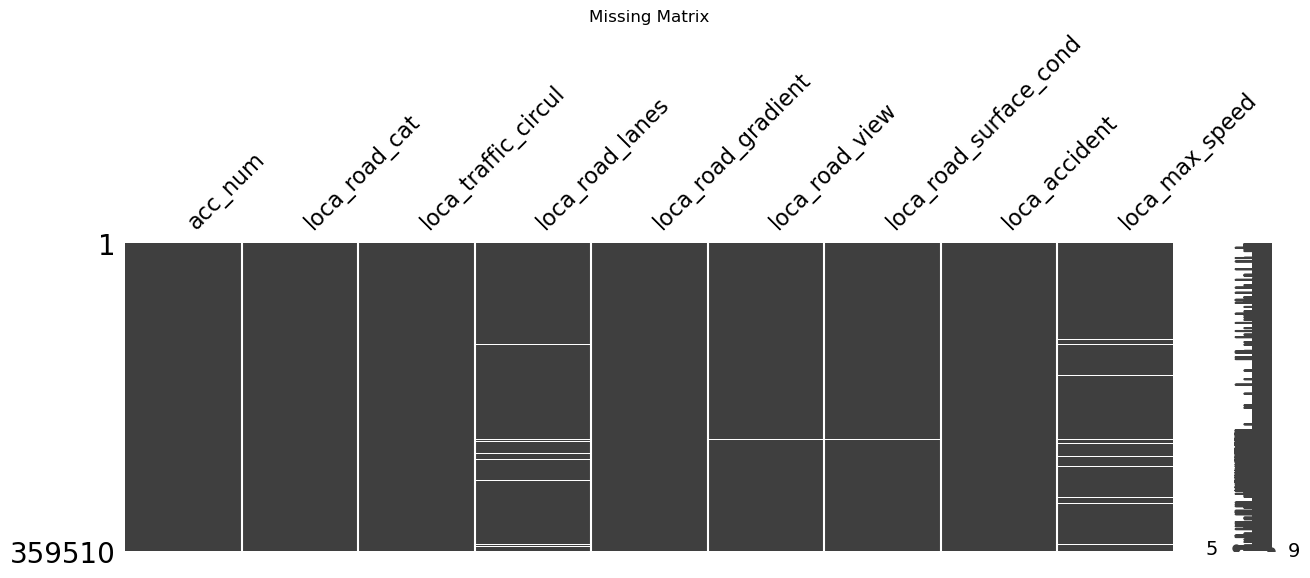

In [41]:
# missing matrix
msno.matrix( df, 
             figsize=(15,4) )
plt.title( 'Missing Matrix' )
plt.show()

In [ ]:
# ---------------------
# uni-variant analysis
# ---------------------


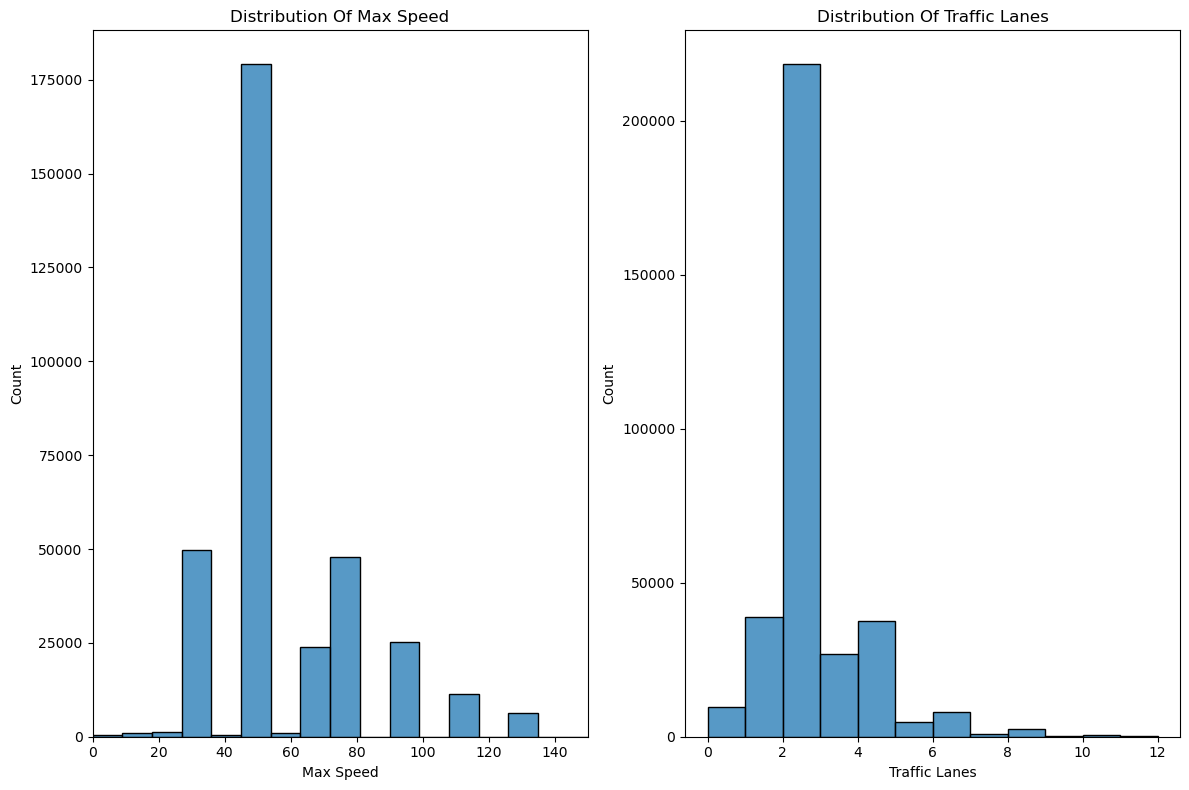

In [42]:
# quantitative (numerical)
# histogram, kde
# { :sns.displot(kind=’hist’), :sns.displot(kind=’kde’) }

# 1x2 matrix
fig, axes = plt.subplots( 1,
                          2,
                          figsize=(12,8) )

# flatten axes
axes = axes.flatten()

# histogram 1 - max speed
sns.histplot( data=df.loca_max_speed,
              bins=20,
              ax=axes[0] )
axes[0].set_title( 'Distribution Of Max Speed' )
axes[0].set_xlabel( 'Max Speed' )
axes[0].set_ylabel( 'Count' )
axes[0].set_xlim( [0, 150] )

# histogram 2 - total number of traffic lanes
sns.histplot( data=df.loca_road_lanes,
              bins=12,
              ax=axes[1] )
axes[1].set_title( 'Distribution Of Traffic Lanes' )
axes[1].set_xlabel( 'Traffic Lanes' )
axes[1].set_ylabel( 'Count' )

plt.tight_layout()
plt.show()

# insights
# :max_speed
#    most road accidents happen in 50 zones
#    followed by equally often in 30 and 80 zones
#    then by equally often in 70 and 90 zones
# :traffic_lanes
#    significantly often road accidents happen on 2 lanes
#    followed by equally often on 1 and 4 lanes


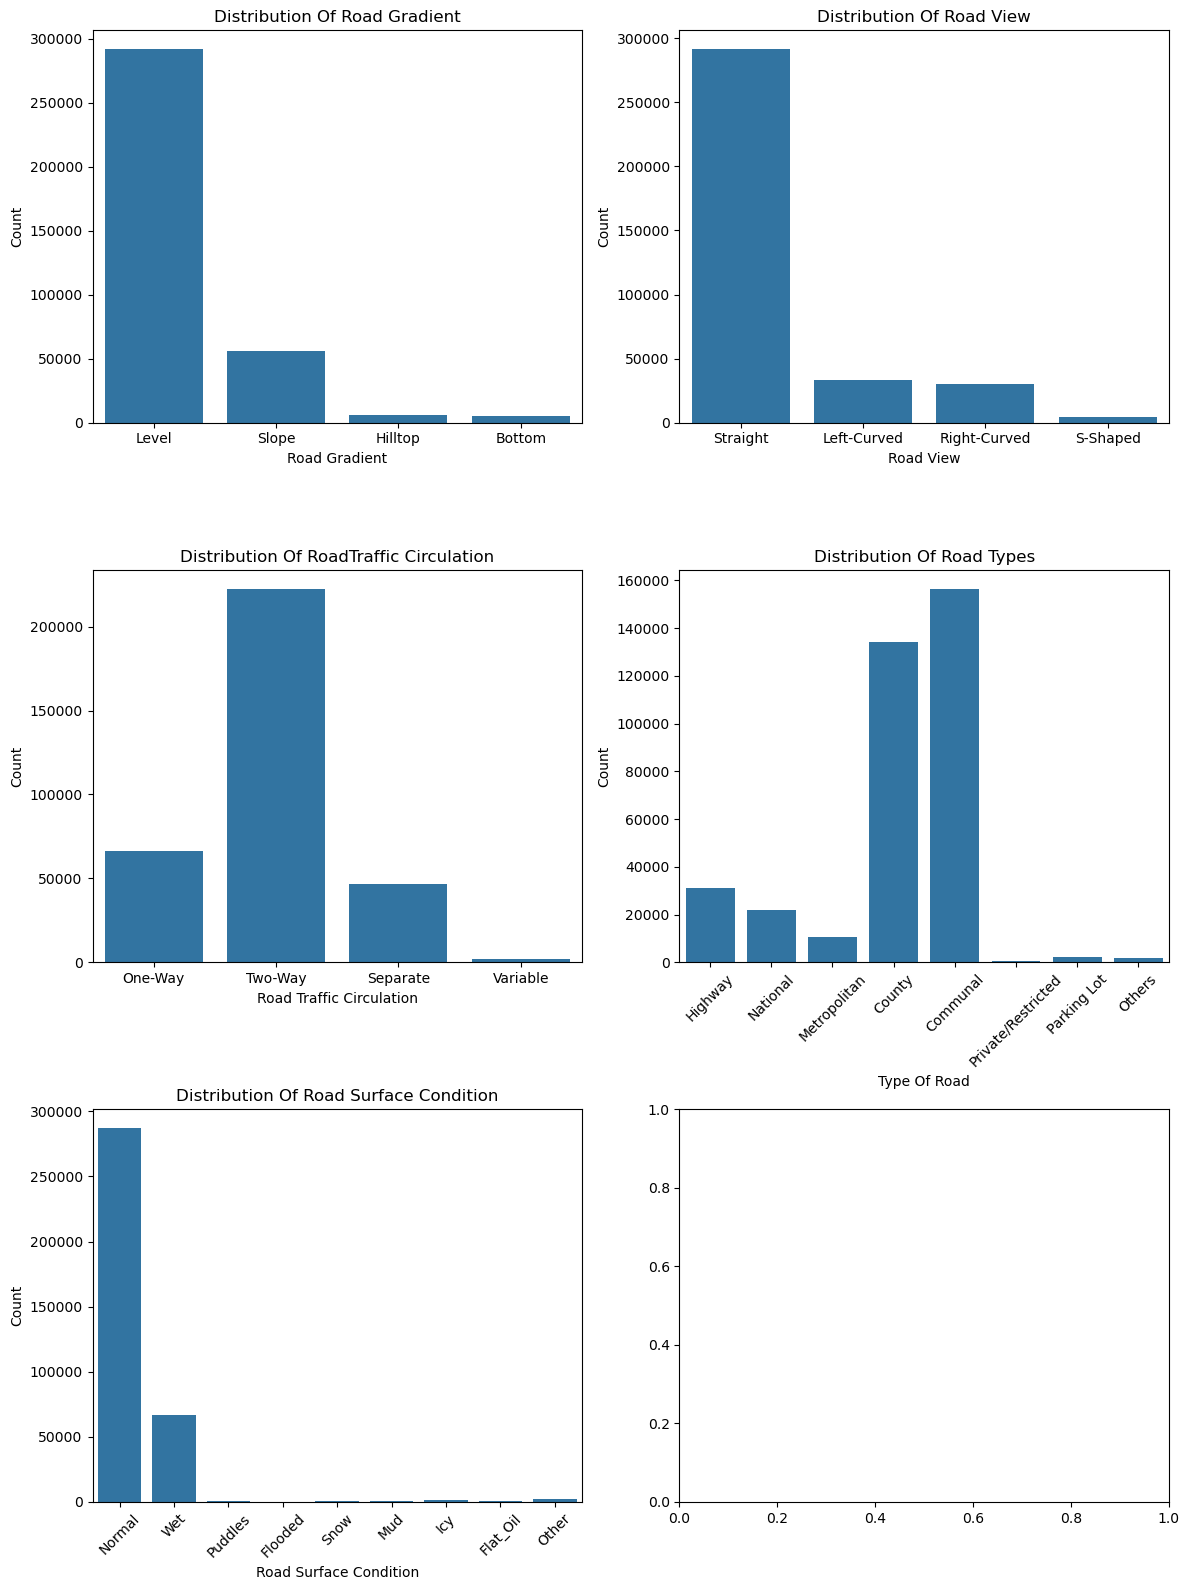

In [43]:
# qualitative (categorical)
# countplot, frequency table
# method = { :sns.countplot(), :sns.catplot(kind=’count’) }

# 3x2 matrix
fig, axes = plt.subplots( 3,
                          2,
                          figsize=(12,16) )

# flatten axes
axes = axes.flatten()

# plot 1 - road gradient
# (-1) :missing, (1) :level, (2) :slope, (3) :top, (4) :bottom
# to match labels to codes and to align lables correctly in plot
road_gradient_labels = {
    1: 'Level',
    2: 'Slope',
    3: 'Hilltop',
    4: 'Bottom'
}

road_gradient_codes = range( 1, 5 )
road_gradient_order = [ road_gradient_labels[i] for i in road_gradient_codes ]

# mapping
df_tmp = pd.DataFrame()
df_tmp[ 'road_gradient_labels' ] = df.loca_road_gradient.map( road_gradient_labels )

sns.countplot( data=df,
               x=df_tmp.road_gradient_labels,
               order=road_gradient_order,
               ax=axes[0] )
axes[0].set_title( 'Distribution Of Road Gradient' )
axes[0].set_xlabel( 'Road Gradient' )
axes[0].set_ylabel( 'Count' )


# plot 2 - road view
# (-1) :missing, (1) :straight_part, 
# (2) :curved_left, (3) :cuvred_right, (4) :in_s
# to match labels to codes and to align lables correctly in plot
road_view_labels = {
    1: 'Straight',
    2: 'Left-Curved',
    3: 'Right-Curved',
    4: 'S-Shaped'
}

road_view_codes = range( 1, 5 )
road_view_order = [ road_view_labels[i] for i in road_view_codes ]

df_tmp[ 'road_view_labels' ] = df.loca_road_view.map( road_view_labels )

sns.countplot( data=df,
               x=df_tmp.road_view_labels,
               order=road_view_order,
               ax=axes[1] )
axes[1].set_title( 'Distribution Of Road View' )
axes[1].set_xlabel( 'Road View' )
axes[1].set_ylabel( 'Count' )


# plot 3 - traffic circulation
# (-1) :missing, (1) :one_way, (2) :two_way, 
# (3) :separate_lanes, (4) :varaible_assignment_channels
road_traffic_circ_labels = {
    1: 'One-Way',
    2: 'Two-Way',
    3: 'Separate',
    4: 'Variable'
}

road_traffic_circ_codes = range( 1, 5 )
road_traffic_circ_order = [ road_traffic_circ_labels[i] for i in road_traffic_circ_codes ]

df_tmp[ 'road_traffic_circ_labels' ] = df.loca_traffic_circul.map( road_traffic_circ_labels )

sns.countplot( data=df,
               x=df_tmp.road_traffic_circ_labels,
               order=road_traffic_circ_order,
               ax=axes[2] )
axes[2].set_title( 'Distribution Of RoadTraffic Circulation' )
axes[2].set_xlabel( 'Road Traffic Circulation' )
axes[2].set_ylabel( 'Count' )


# plot 4 - road type
# (1) :highway, (2) :national_road, (3) :urban_metropolitan_road, 
# (4) :county_road, (5) :communal_road, (6) :private_restricted_road, 
# (7) :public_parking_lot, (8) :others
road_type_labels = {
    1: 'Highway',
    2: 'National',
    3: 'Metropolitan',
    4: 'County',
    5: 'Communal',
    6: 'Private/Restricted',
    7: 'Parking Lot',
    8: 'Others'
}

road_type_codes = range(1, 9)
road_type_order = [ road_type_labels[i] for i in road_type_codes ]

df_tmp[ 'road_type_labels' ] = df.loca_road_cat.map( road_type_labels )

sns.countplot( data=df,
               x=df_tmp.road_type_labels,
               order=road_type_order,
               ax=axes[3] )
axes[3].set_title( 'Distribution Of Road Types' )
axes[3].set_xlabel( 'Type Of Road' )
axes[3].set_ylabel( 'Count' )
axes[3].tick_params( axis='x',
                     rotation=45 )

# plot 5 - surface condition
# (-1) :missing, (1) :normal, (2) :wet, (3) :puddles, 
# (4) :flooded, (5) :snow, (6) :mud, (7) :icy, (8) :fat_oil, (9) :other
road_surface_labels = {
    1: 'Normal',
    2: 'Wet',
    3: 'Puddles',
    4: 'Flooded',
    5: 'Snow',
    6: 'Mud',
    7: 'Icy',
    8: 'Flat_Oil',
    9: 'Other'
}

road_surface_codes = range(1, 10)
road_surface_order = [ road_surface_labels[i] for i in road_surface_codes ]

df_tmp[ 'road_surface_labels' ] = df.loca_road_surface_cond.map( road_surface_labels )

sns.countplot( data=df,
               x=df_tmp.road_surface_labels,
               order=road_surface_order,
               ax=axes[4] )
axes[4].set_title( 'Distribution Of Road Surface Condition' )
axes[4].set_xlabel( 'Road Surface Condition' )
axes[4].set_ylabel( 'Count' )
axes[4].tick_params( axis='x',
                     rotation=45 )

plt.tight_layout()
plt.show()

# insights
# :road_gradient
#    most accidents happen on even road conditions
#    less accidents happen when road goes uphill or downhill
#    significantly less accidents are on hill tops or on the bottom of a hill
# :view
#    most accidents happen when the view is straight
#    followed by equal accidents when road turns left or right
#    in s curves are the least accidents happening
# :traffic_circulation
#    most accidents happend on 2-lane roads which correlates with
#    variable :total_lanes
#    less but equally often happen accidents on 1-way and separate lanes
#    which also correlates with findings in variable :total_lanes
# :road_type
#    most accidents happend on communal and county roads which correlates
#    with findings of traffic circulation and traffic lanes
#    significantly less accidents happen on highways and national roads
# :surface_condition
#    most accidents happen when street is dry
#    followed by accidents on wet streets


In [ ]:
# ----------------------------
# bi- / multi-variant analysis
# -----------------------------

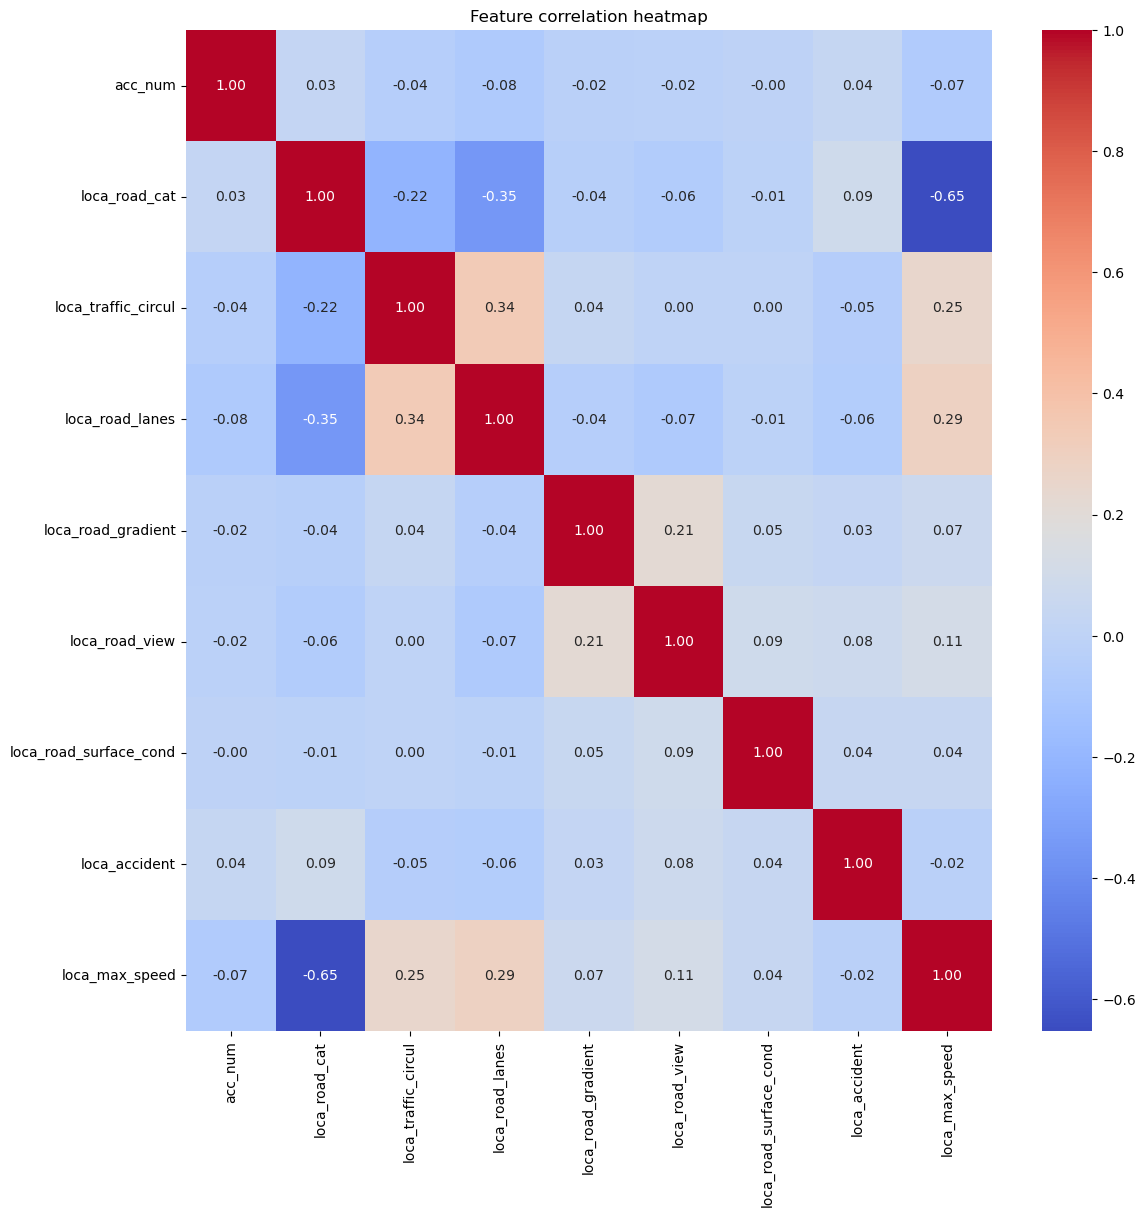

In [44]:
# quantitative vs. quantitative
# method = { Pearson/Spearman: :sns.heatmap(df.corr()), 
#            linear_relationship: :sns.scatterplot() }

# heatmap
plt.figure( figsize=(13,13) )
sns.heatmap(
    df.corr( numeric_only=True ),
    annot=True,
    fmt='.2f',
    cmap='coolwarm'
)
plt.title( 'Feature correlation heatmap' )
plt.show()

# insights (heatmap)
# overall
#    low overall correlation
#        most variables have weak correlation |r| < 0.2
#        suggesting features have unique info
#        redundancy between predictors is low
# positive correlation
#    moderate
#        :prof (road gradient) has moderate pos. corr with
#            :plan (view) (0.22)
#            => road gradient impacts view on the street
#    weak
#        :circ (traffic circulation)
#            :vma (max speed) (0.2)
#            => one-way has lower speed, separate lanes have higher speed
#        :catr (road type) has weak pos. corr. with
#            :situ (accident situation) (0.07)
#            :infra (infrastructure) (0.05)
#            :vosp (reserved lane) (0.12)
#            => road type affects accident situation, infrastructure, and
#               if it a reserved lane was present
#        :v1 (road number) has weak pos. corr. with
#            :vosp (reserved lane) (0.15)
#            => some roads have reserved lanes
#        :vosp (reserved lane) has weak pos. corr. with
#            :situ (accident situation) (0.13)
#            :v1 (road number) (0.15)
#            :catr (road type) (0.12)
#            => reserved lanes during accident,
#               influence accident situation, road number, and road type
#        :plan (view) has weak pos. corr. with
#            :vma (max speed) (0.1)
#            :surf (surface condition) (0.09)
#            :situ (accident situation) (0.08)
#            => the view affects the max allowed speed, 
#               the surface condition and accident situation
#        :infra (infrastructure) has weak pos. corr. with
#            :situ (accident situation) (0.08)
#            => infrastructure affects the accident situation
# negative correlation
#    moderate
#        :catr (road type) has moderate neg. corr. with
#            :vma (max speed) (-0.48)
#            => the road type influences the max allowed speed
#    weak
#        :catr (road type) has weak neg. corr. with
#            :circ (traffic circulation) (-0.17)
#            => the road type influences the traffic circulation
#        :infra (infrastructure) has weak neg. corr. with
#            :vma (max speed) (-0.08)
#            => the infrastructure influences max allowed speed
#        :vma (max speed) has weak neg. corr. with
#            :vosp (reserved lane) (-0.08)
#            =>


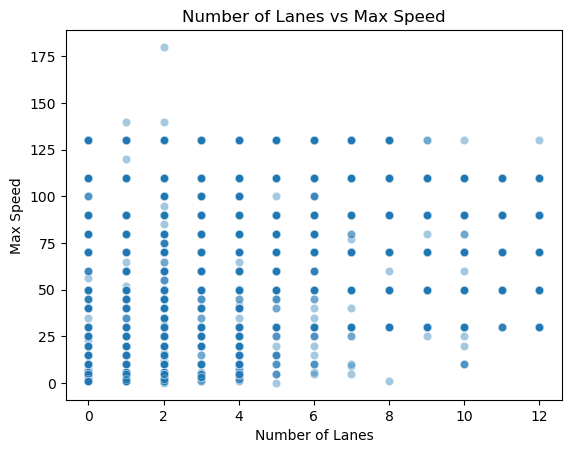

In [45]:
# quantitative vs. quantitative
# method = { Pearson/Spearman: :sns.heatmap(df.corr()), 
#            linear_relationship: :sns.scatterplot() }

# relationship between max speed and traffic lanes
# >= 2 quantitative
# scatterplot

# 1x1 matrix

# plot 1 - road lanes vs. speed
sns.scatterplot( x='loca_road_lanes',
                 y='loca_max_speed',
                 data=df,
                 alpha=0.4 )
plt.title( 'Number of Lanes vs Max Speed' )
plt.xlabel( 'Number of Lanes' )
plt.ylabel( 'Max Speed' )



plt.show()

# insight
# it seems that no matter how many lanes the road has people drive fast

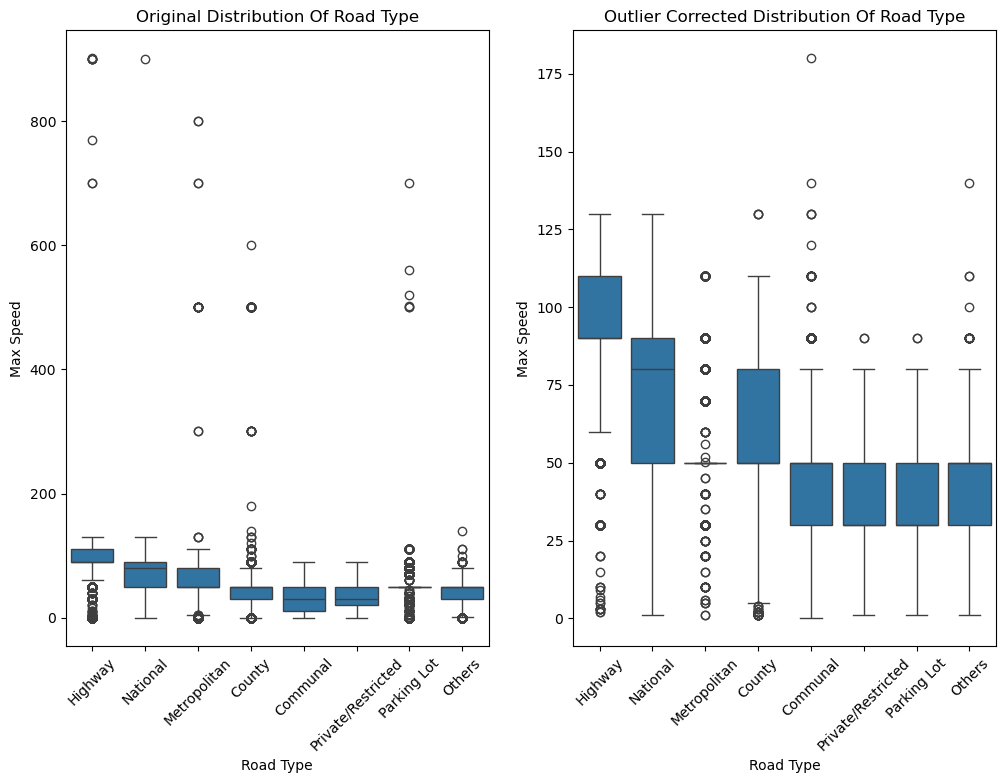

In [46]:
# qualitative vs. quantitative
# method = { distribution: :sns.boxplot() }

# key numerical = { :lanes, :speed }
# key categorical = { :road_gradient, :view, :traffic_circulation, 
#                     :road_type, :surface }

# 1x2 matrix
fig, axes = plt.subplots( 1,
                          2,
                          figsize=(12,8) )

# flatten axes
axes = axes.flatten()

# boxplot 1 - with outliers
# road type (1) :highway, (2) :national_road, (3) :urban_metropolitan_road, 
#           (4) :county_road, (5) :communal_road, (6) :private_restricted_road, 
#           (7) :public_parking_lot, (8) :others
# road view = (-1) :missing, (1) :straight_part, 
#             (2) :curved_left, (3) :curved_right, (4) :s_shaped
road_type_labels_orig = {
    1: 'Highway',
    2: 'National',
    3: 'Metropolitan',
    4: 'County',
    5: 'Communal',
    6: 'Private/Restricted',
    7: 'Parking Lot',
    9: 'Others'
}

road_type_codes_orig = [ 1, 2, 3, 4, 5, 6, 7, 9 ]
road_type_order_org = [ road_type_labels_orig[i] for i in road_type_codes_orig ]

# mapping
df_tmp2 = pd.DataFrame()
df_tmp2[ 'road_type_labels_orig' ] = df_orig.catr.map( road_type_labels_orig )

sns.boxplot( data=df_orig,
             x=df_tmp2.road_type_labels_orig,
             y='vma',
             order=road_type_order_org,
             ax=axes[0] )
axes[0].set_title( 'Original Distribution Of Road Type' )
axes[0].set_xlabel( 'Road Type' )
axes[0].set_ylabel( 'Max Speed' )
axes[0].tick_params( axis='x',
                     rotation=45 )



# boxplot 2 - outliers cleaned
road_type_labels = {
    1: 'Highway',
    2: 'National',
    3: 'Metropolitan',
    4: 'County',
    5: 'Communal',
    6: 'Private/Restricted',
    7: 'Parking Lot',
    8: 'Others'
}

road_type_codes = range(1, 9)
road_type_order = [ road_type_labels[i] for i in road_type_codes ]

df_tmp2[ 'road_type_labels' ] = df.loca_road_cat.map( road_type_labels )

sns.boxplot( data=df,
             x=df_tmp2.road_type_labels,
             y='loca_max_speed',
             order=road_type_order,
             ax=axes[1] )
axes[1].set_title( 'Outlier Corrected Distribution Of Road Type' )
axes[1].set_xlabel( 'Road Type' )
axes[1].set_ylabel( 'Max Speed' )
axes[1].tick_params( axis='x',
                     rotation=45 )


plt.show()


# insights
# key takeaway
# outliers are reporting issues
#     for example speed of 800 was typo of speed 80 (there are many similar outliers)
# (1) highways
#     have tight spread of speed
#     IQR is therefor tight
#     has no middle line -> median does not exist, not visible
#     whiskers are tight
#     has outliers on both sides -> outliers > 700 speed are reporting issues
# (2) national roads
#     have broader spread of speed
#     middle line (median) is at ~100 speed
#     has broadest whiskers at bottom are ~0 and top ~150 speed
#     has outlier at > 850 speed
# (3) county roads
#     are a bit tighter than national roads
#     has no middle line (median)
#     has approx. similar whiskerys to national roads
#     has more outliers than highways and national roads starting at ~160 speed
# (4) communal roads
#     has tight spread of spead
#     has no median
#     has whiskers from 0 - 100 speed
#     has many outliers starting at ~100
# (5+6) parking lots + no public road
#     are very similar; similar whiskers, similar median, similar spread
#     have no outliers


# how to read boxplot
# box         -> each box represents spread of road type for max speed
# box edges   -> IQR = 25th + 75th percentiles (interquartile range)
# middle line -> median of road width
# whiskers    -> 1.5xIQR from box edges
# points      -> outliers



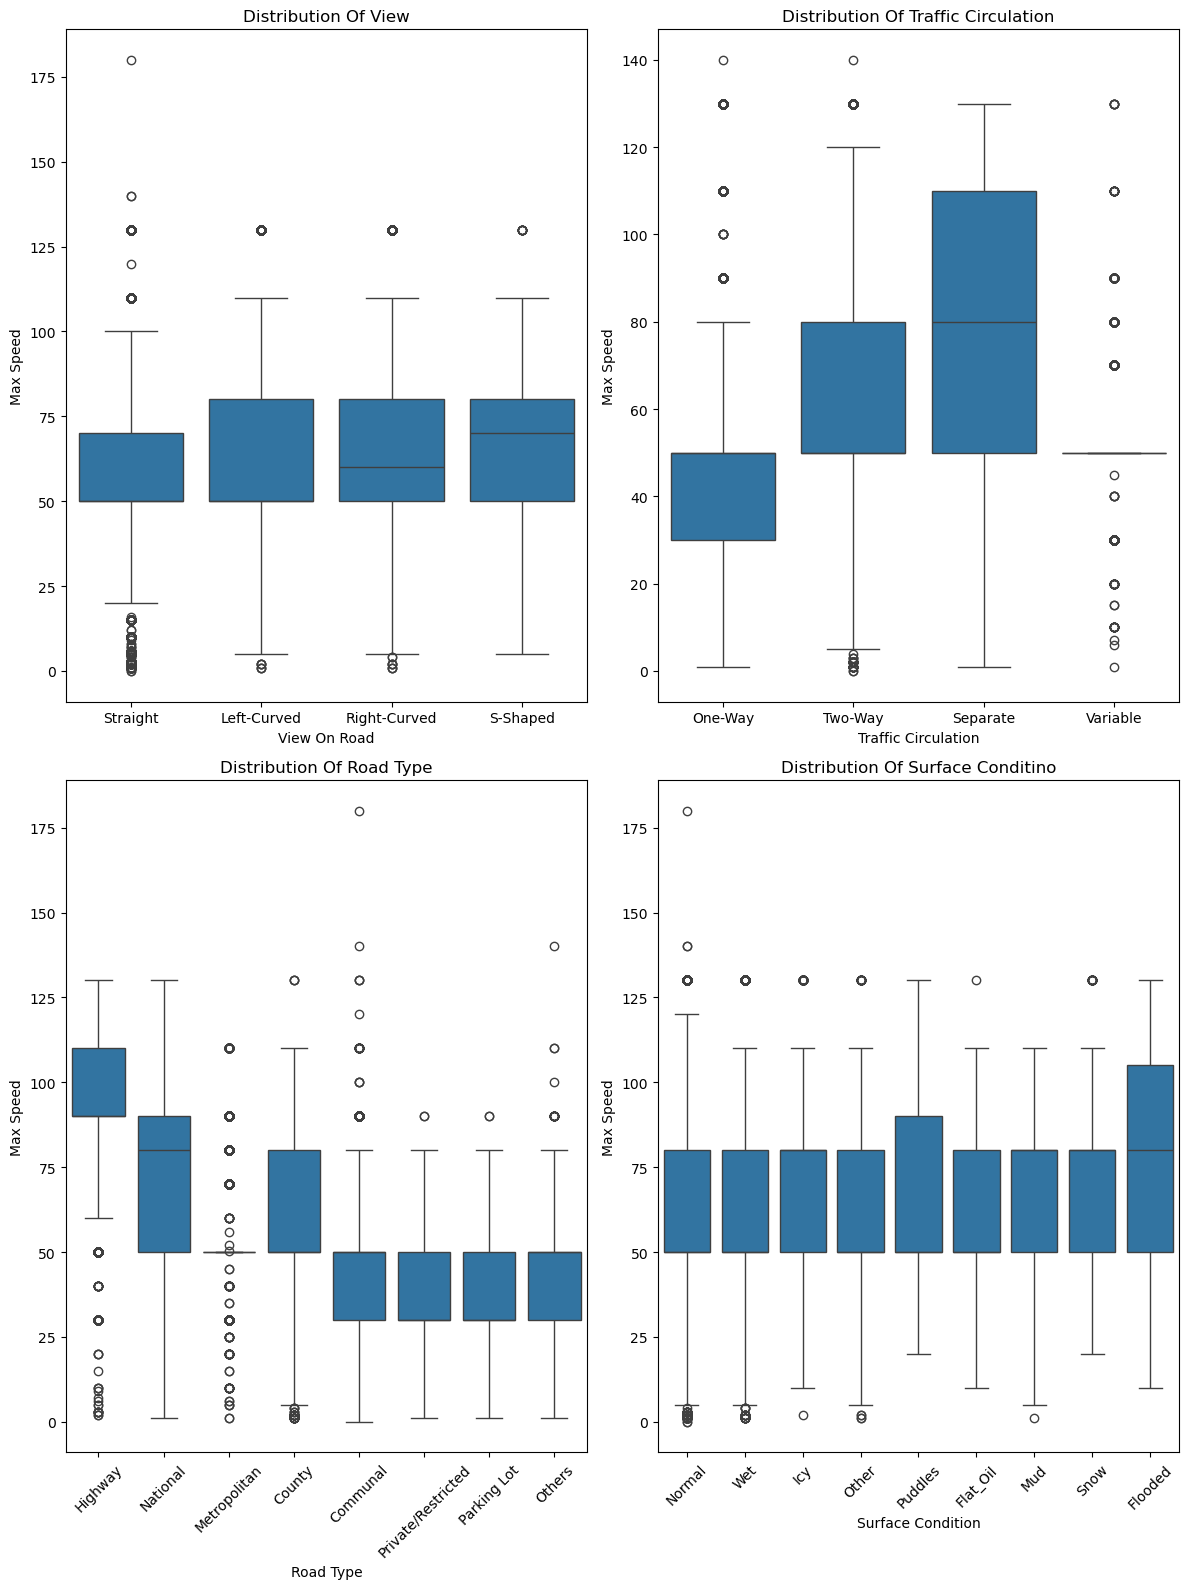

In [47]:
# boxplot
# 3x2 matrix
fig, axes = plt.subplots( 2,
                          2,
                          figsize=(12,16) )

# flatten axes
axes = axes.flatten()

# boxplot 1 - view vs. speed
road_view_labels = {
    1: 'Straight',
    2: 'Left-Curved',
    3: 'Right-Curved',
    4: 'S-Shaped'
}

road_view_codes = range( 1, 5 )
road_view_order = [ road_view_labels[i] for i in road_view_codes ]

df_tmp = pd.DataFrame()
df_tmp[ 'road_view_labels' ] = df.loca_road_view.map( road_view_labels )

sns.boxplot( data=df,
             x=df_tmp.road_view_labels,
             y='loca_max_speed',
             order=road_view_order,
             ax=axes[0] )
axes[0].set_title( 'Distribution Of View' )
axes[0].set_xlabel( 'View On Road' )
axes[0].set_ylabel( 'Max Speed' )


# boxplot 2 - traffic circulation vs. speed
road_traffic_circ_labels = {
    1: 'One-Way',
    2: 'Two-Way',
    3: 'Separate',
    4: 'Variable'
}

road_traffic_circ_codes = range( 1, 5 )
road_traffic_circ_order = [ road_traffic_circ_labels[i] for i in road_traffic_circ_codes ]

df_tmp[ 'road_traffic_circ_labels' ] = df.loca_traffic_circul.map( road_traffic_circ_labels )

sns.boxplot( data=df,
             x=df_tmp.road_traffic_circ_labels,
             y='loca_max_speed',
             order=road_traffic_circ_order,
             ax=axes[1] )
axes[1].set_title( 'Distribution Of Traffic Circulation' )
axes[1].set_xlabel( 'Traffic Circulation' )
axes[1].set_ylabel( 'Max Speed' )


# boxplot 3 - road type vs. speed
road_type_labels = {
    1: 'Highway',
    2: 'National',
    3: 'Metropolitan',
    4: 'County',
    5: 'Communal',
    6: 'Private/Restricted',
    7: 'Parking Lot',
    8: 'Others'
}

road_type_codes = range(1, 9)
road_type_order = [ road_type_labels[i] for i in road_type_codes ]

df_tmp[ 'road_type_labels' ] = df.loca_road_cat.map( road_type_labels )


sns.boxplot( data=df,
             x=df_tmp.road_type_labels,
             y='loca_max_speed',
             order=road_type_order,
             ax=axes[2] )
axes[2].set_title( 'Distribution Of Road Type' )
axes[2].set_xlabel( 'Road Type' )
axes[2].set_ylabel( 'Max Speed' )
axes[2].tick_params( axis='x',
                     rotation=45 )


# boxplot 4 - surface vs. speed
road_surface_labels = {
    1: 'Normal',
    2: 'Wet',
    3: 'Puddles',
    4: 'Flooded',
    5: 'Snow',
    6: 'Mud',
    7: 'Icy',
    8: 'Flat_Oil',
    9: 'Other'
}

road_surface_codes = range(1, 10)
road_surface_order = [ road_surface_labels[i] for i in road_surface_codes ]

df_tmp[ 'road_surface_labels' ] = df.loca_road_surface_cond.map( road_surface_labels )

sns.boxplot( data=df,
             x=df_tmp.road_surface_labels,
             y='loca_max_speed',
             ax=axes[3] )
axes[3].set_title( 'Distribution Of Surface Conditino' )
axes[3].set_xlabel( 'Surface Condition' )
axes[3].set_ylabel( 'Max Speed' )
axes[3].tick_params( axis='x',
                     rotation=45 )


plt.tight_layout()
plt.show()



In [48]:
# qualitative vs. qualitative
#  method = { contingency_table: :pd.crosstab() }

# key categorical = { :road_gradient, :road_view, :road_traffic_circulation, 
#                     :road_type, :road_surface }

# 1 contingency table - road type vs. traffic circulation
# finding frequency / proportion of road type based on traffic circulation
# catr = (1) :highway, (2) :national_road, (3) :county_road, 
#        (4) :communal_road, (5) :no_public_road, 
#        (6) :public_parking_lot, (7) :<unknown>, (9) :others
# circ = (-1) :<undefined>, (1) :one_way, (2) :two_way, 
#        (3) :separate_lanes, (4) :varaible_assignment_channels
ct_rt_tc = pd.crosstab( df.loca_road_cat, 
                        df.loca_traffic_circul )

# hypotheses
# H0: road type is independent of road traffic circulation
# H1: road type is dependent of traffic circulation

# chi^2
chi2_rt_tc = chi2_contingency( ct_rt_tc )

# display p-value
display( chi2_rt_tc[1] )

# Cramer's V
cramers_v_rt_tc = np.sqrt( chi2_rt_tc[0] / ct_rt_tc.values.sum() )

# display Cramer's V
display( cramers_v_rt_tc )

# insight
# chi-square
#    p(0.0) < alpha=0.05
#    reject H0 (independence); accept H1 (dependence)
#    suggesting association exists between road type and traffic circulation
# Cramer's V
#    value of 0.62 is high, suggesting strong strength


# contingency table - road gradient vs. road view
# finding frequency / proportion of road gradient based on view
# prof = (-1) :missing, (1) :level, (2) :slope, (3) :top, (4) :bottom
# plan = (-1) :missing, (1) :straight_part, 
#        (2) :curved_left, (3) :cuvred_right, (4) :in_s
ct_rg_rv = pd.crosstab( df.loca_road_gradient, 
                        df.loca_road_view )


# hypotheses
# H0: road gradient is independent of road view
# H1: road gradient is depenedent of road view

# chi^2
chi2_rg_rv = chi2_contingency( ct_rg_rv)

# display p-value
display( chi2_rg_rv[1] )

# Cramer's V
cramers_v_rg_rv = np.sqrt( chi2_rg_rv[0] / ct_rg_rv.values.sum() )

# display Cramer's V
display( cramers_v_rg_rv )

# insight
# chi-square
#    p(0.0) < alpha=0.05
#    reject H0 (independence); accept H1 (dependence)
#    suggesting association exists between  road gradient and the road view
# Cramer's V
#    value of 0.25 suggests 


np.float64(0.0)

np.float64(0.6193207560316476)

np.float64(0.0)

np.float64(0.24466137542473193)